# Amazon Prime Catalog — Exploratory Data Analysis (EDA)

This notebook explores a publicly available Amazon Prime catalog dataset.

**Goals**
- Understand catalog composition (Movies vs TV Shows)
- Inspect runtime (mins) vs seasons distributions
- Explore genre and country distributions
- Explore cast-size patterns and “unique actors per genre”

## Reproducibility & Assumptions

- The dataset is *catalog-level* metadata (no user watch history).
- File paths are relative so this notebook runs after cloning the repo.
- Cleaning is handled by `clean_streaming_df()` from `streaming_func.py`.

In [13]:
# Import core libraries and project utilities
from pathlib import Path

import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt

from streaming_func import clean_streaming_df, unique_actors_per_genre, plot_top_unique_actors, plot_top_countries

In [14]:
# Loading Amazon Prime csv dataset & displaying first few entries for understanding structure & content
DATA_DIR = Path("data")
CSV_PATH = DATA_DIR / "amazon_prime_titles.csv"

amazon_df = pd.read_csv(CSV_PATH)
amazon_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


## Cleaning

Here, we standardise:
- column names
- multi-value columns (`cast`, `country`, `listed_in`) into Python lists
- duration into two numeric columns:
  - `duration_mins` for Movies
  - `duration_seasons` for TV Shows

### Note on platform-specific cleaning

Earlier iterations of this notebook included an Amazon-specific cleaning function.
This logic has been moved into `streaming_func.py` to keep notebooks lightweight, reusable, & focused on analysis.

The `clean_streaming_df()` function standardises column formats & converts multi-value fields (cast/country/genres) into lists, which enables consistent EDA across platforms.

In [15]:
# Using refined 'clean_streaming_df' function from streaming_func.py to clean Amazon Prime dataset, with its unique genre exception
clean_amazon_df = clean_streaming_df(amazon_df)
clean_amazon_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_mins,duration_seasons
0,s1,Movie,The Grand Seduction,Don McKellar,"[Brendan Gleeson, Taylor Kitsch, Gordon Pinsent]",[Canada],"March 30, 2021",2014,NaN,113 min,"[Comedy, Drama]",A small fishing village must procure a local d...,113,<NA>
1,s2,Movie,Take Care Good Night,Girish Joshi,"[Mahesh Manjrekar, Abhay Mahajan, Sachin Khede...",[India],"March 30, 2021",2018,13+,110 min,"[Drama, International]",A Metro Family decides to fight a Cyber Crimin...,110,<NA>
2,s3,Movie,Secrets of Deception,Josh Webber,"[Tom Sizemore, Lorenzo Lamas, Robert LaSardo, ...",[United States],"March 30, 2021",2017,NaN,74 min,"[Action, Drama, Suspense]",After a man discovers his wife is cheating on ...,74,<NA>
3,s4,Movie,Pink: Staying True,Sonia Anderson,"[Interviews with: Pink, Adele, Beyoncé, Britne...",[United States],"March 30, 2021",2014,NaN,69 min,[Documentary],"Pink breaks the mold once again, bringing her ...",69,<NA>
4,s5,Movie,Monster Maker,Giles Foster,"[Harry Dean Stanton, Kieran O'Brien, George Co...",[United Kingdom],"March 30, 2021",1989,NaN,45 min,"[Drama, Fantasy]",Teenage Matt Banting wants to work with a famo...,45,<NA>


## Quick dataset breadth checks (genres & production countries)

Before plotting, we compute how many unique genres & countries appear in the catalog.
This is a simple “breadth” sanity-check that also helps interpret long-tail plots later.

In [16]:
# Extracting unique genre types & countries from the 'listed_in' & 'country' columns respectively for Amazon Prime dataset
amazon_prime_genres = sorted(set(chain.from_iterable(clean_amazon_df["listed_in"])))
amazon_prime_countries = sorted(set(chain.from_iterable(clean_amazon_df["country"])))

print(f'Total unique genres for Amazon Prime media: {len(amazon_prime_genres)}')
print(f'Total unique production countries for Amazon Prime media: {len(amazon_prime_countries)}')

Total unique genres for Amazon Prime media: 29
Total unique production countries for Amazon Prime media: 45


## Split into Movies vs TV Shows

Many analyses differ by type (e.g. duration in minutes vs seasons), so we create two filtered dataframes.

In [27]:
# Movies-only & TV-Shows-only dataframe partitions of the cleaned Amazon Prime dataset
clean_shows_df = clean_amazon_df[clean_amazon_df["type"] == "TV Show"].copy()
clean_movies_df = clean_amazon_df[clean_amazon_df["type"] == "Movie"].copy()

clean_shows_df.shape, clean_movies_df.shape, clean_amazon_df.shape

((1854, 14), (7814, 14), (9668, 14))

## Movie runtime distribution (minutes)

We inspect the distribution of movie runtimes to understand typical lengths & whether outliers exist.


### Movie Runtime Distribution

To understand the typical length of movies on Amazon Prime, I visualised the
distribution of movie runtimes. Extreme outliers (very long runtimes, e.g.
special editions or misclassified entries) were excluded to avoid skewing the
visualisation.

The distribution shows a strong concentration around standard feature-length
films (~90 minutes), with a right-skewed tail representing longer productions.

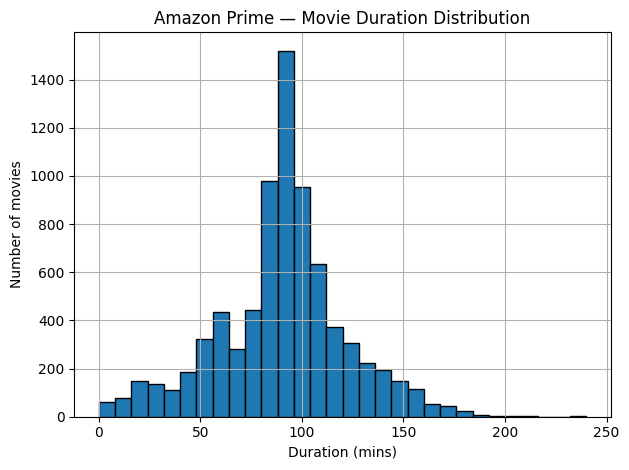

In [18]:
# Focus on typical feature-length films (exclude extreme outliers)
filtered_movies = clean_movies_df[clean_movies_df["duration_mins"] <= 250]

filtered_movies["duration_mins"].dropna().astype(int).hist(
    bins=30,
    edgecolor="black"
)

plt.title("Amazon Prime — Movie Duration Distribution")
plt.xlabel("Duration (mins)")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

> *Findings:* Movie runtimes cluster around typical feature-length durations, with a long tail of unusually short/long titles. Outliers are expected due to specials, compilations, & metadata noise.

## TV Show seasons distribution

Here, we inspect how many seasons TV shows on Amazon Prime typically have.

To keep the plot readable, we focus on shows up to a chosen season threshold (long-running outliers exist).

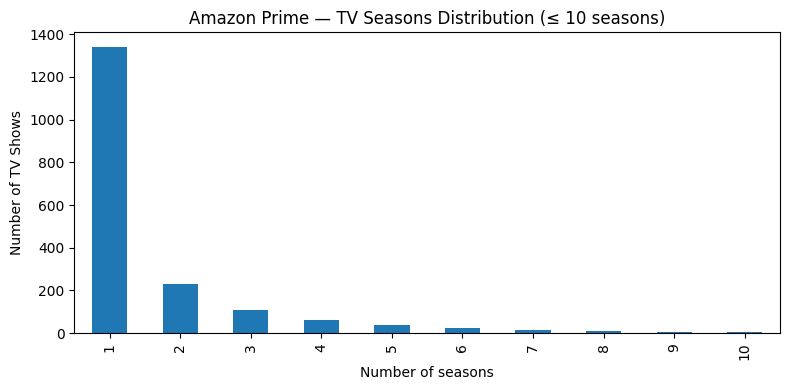

In [19]:
# Filtering for TV shows with 10 seasons or less, as few tv shows ever suceed enough to exceed this number
max_seasons = 10

filtered_tv = clean_shows_df[clean_shows_df["duration_seasons"].notna() & (clean_shows_df["duration_seasons"] <= max_seasons)]

shows_ax = filtered_tv.groupby("duration_seasons").size().plot(kind="bar", figsize=(8,4))
shows_ax.set_title(f"Amazon Prime — TV Seasons Distribution (≤ {max_seasons} seasons)")
shows_ax.set_xlabel("Number of seasons")
shows_ax.set_ylabel("Number of TV Shows")
plt.tight_layout()
plt.show()

> *Findings:* Most shows have relatively few seasons, with a small number of long-running series creating a long tail.
Filtering improves readability without changing the overall pattern.

## Cast size patterns

Cast lists are imperfect metadata but can still reveal structure:
- TV shows may have larger or more variable casts than movies
- long tails are expected (ensembles / anthology listings)

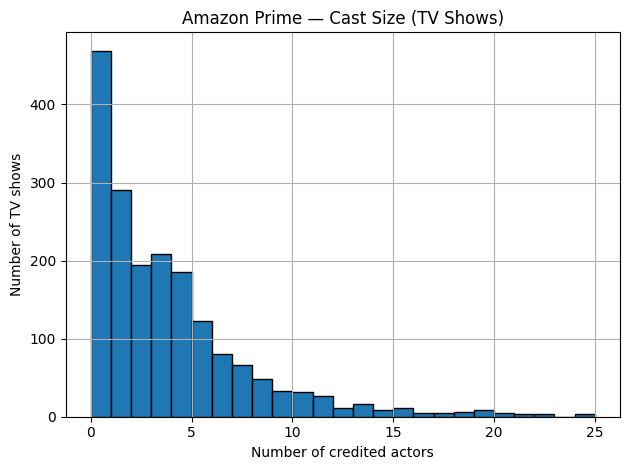

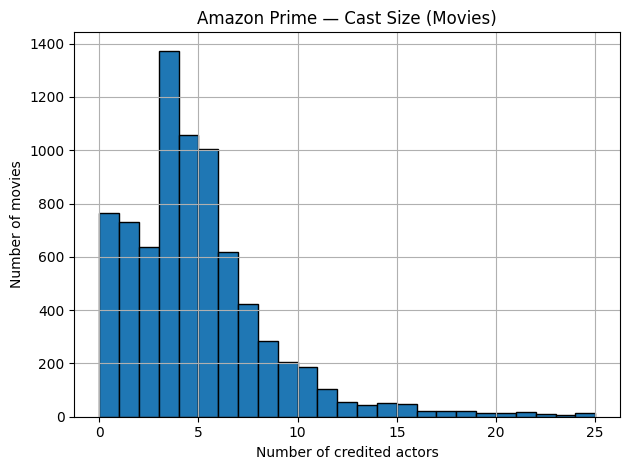

In [20]:
# Histograms of cast sizes in Movies & TV Shows on Amazon Prime
shows_cast = clean_shows_df.assign(cast_count=clean_shows_df["cast"].apply(len))
movies_cast = clean_movies_df.assign(cast_count=clean_movies_df["cast"].apply(len))

shows_cast["cast_count"].hist(bins=range(0, 26), edgecolor='black')
plt.title("Amazon Prime — Cast Size (TV Shows)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of TV shows")
plt.tight_layout()
plt.show()

movies_cast["cast_count"].hist(bins=range(0, 26), edgecolor='black')
plt.title("Amazon Prime — Cast Size (Movies)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()


> *Findings:* Cast-size distributions are right-skewed (many small casts, fewer large ensembles).
This suggests using medians/quantiles when comparing platforms rather than means.

## Unique cast members (sanity check)

We compute the number of unique credited cast names across the catalog.
This is a rough indicator of metadata richness & helps interpret genre/cast aggregation later.

In [21]:
# Extracting unique cast members from the Amazon Prime dataset
amazon_unique_cast = sorted(
    set(actor.strip() for actor in chain.from_iterable(clean_amazon_df["cast"]) if isinstance(actor, str) and actor.strip())
)

print(f"Total unique cast members (Amazon Prime): {len(amazon_unique_cast)}")

Total unique cast members (Amazon Prime): 31848


## Genre-level aggregation (using exploded rows)

In the dataframes of the streaming service, genres are multi-label. To aggregate per genre, we explode `listed_in` so each title contributes to each of its genres.
We then compute cast-related aggregates per genre to explore whether some genres tend to have larger ensembles.

In [22]:
movies_exploded = clean_movies_df.explode("listed_in").assign(cast_count=clean_movies_df["cast"].apply(len))
shows_exploded  = clean_shows_df.explode("listed_in").assign(cast_count=clean_shows_df["cast"].apply(len))

movie_genre_cast = movies_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
show_genre_cast  = shows_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)

print(f'{movie_genre_cast.head(10)} \n\n{show_genre_cast.head(10)}')

listed_in
Drama               18422
Comedy               9803
Action               8357
Suspense             7934
Horror               4171
Romance              3271
Science Fiction      2175
Documentary          2110
Kids                 1936
Special Interest     1670
Name: cast_count, dtype: int64 

listed_in
Drama               2665
Comedy              1380
Kids                1119
TV Shows             741
Suspense             710
Action               677
Documentary          554
Animation            530
Special Interest     477
Romance              450
Name: cast_count, dtype: int64


> *Findings:* Genre aggregates show strong concentration: a small number of genres dominate total credited cast counts.
This likely reflects both catalog size per genre & metadata completeness.

## Unique actors per genre (top N)

We estimate how many distinct cast names appear within each genre.
This is not a perfect measure (metadata quality varies), but it’s a useful proxy for genre “breadth”.

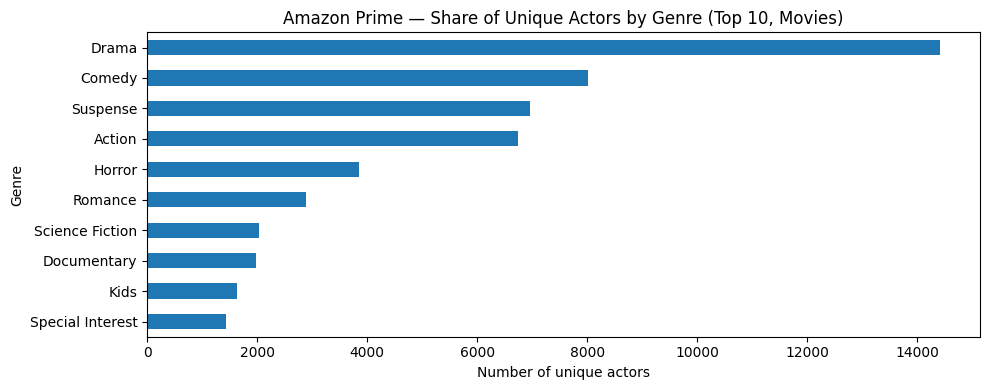

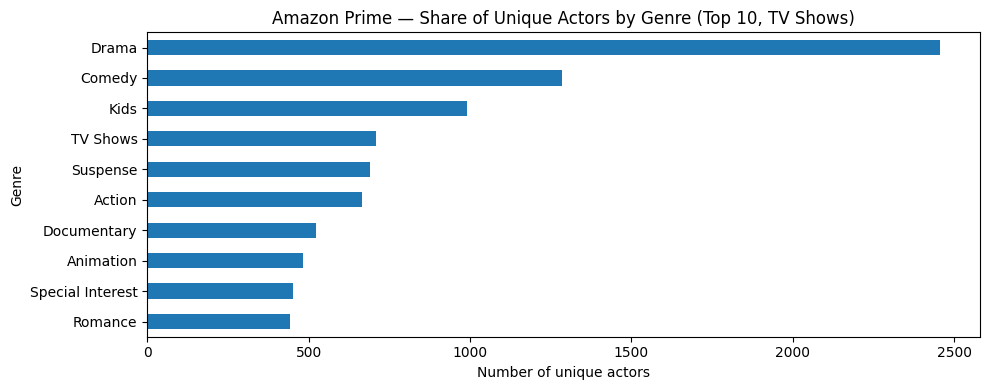

In [23]:
movie_unique_actors_per_genre = unique_actors_per_genre(clean_movies_df)
tv_unique_actors_per_genre = unique_actors_per_genre(clean_shows_df)

plot_top_unique_actors(movie_unique_actors_per_genre, "Amazon Prime — Share of Unique Actors by Genre (Top 10, Movies)")
plot_top_unique_actors(tv_unique_actors_per_genre, "Amazon Prime — Share of Unique Actors by Genre (Top 10, TV Shows)")

> *Note:* I initially plotted two identical pie chart plots for this comparison, but switched to wrapping them with an external function in `streaming_func.py` that would plot them as horizontal bar charts that was helpful in removing any unnecessary duplication whilst ensure consistent formatting, but to also improved readability & provide easier comparison across the available genres.

### Country of Production (Top N)

To analyse geographic production patterns, country lists are exploded so each country
contributes independently to aggregate counts.

A horizontal bar chart is used instead of a pie chart to improve readability & enable
clear comparison across countries, particularly where distributions are skewed.

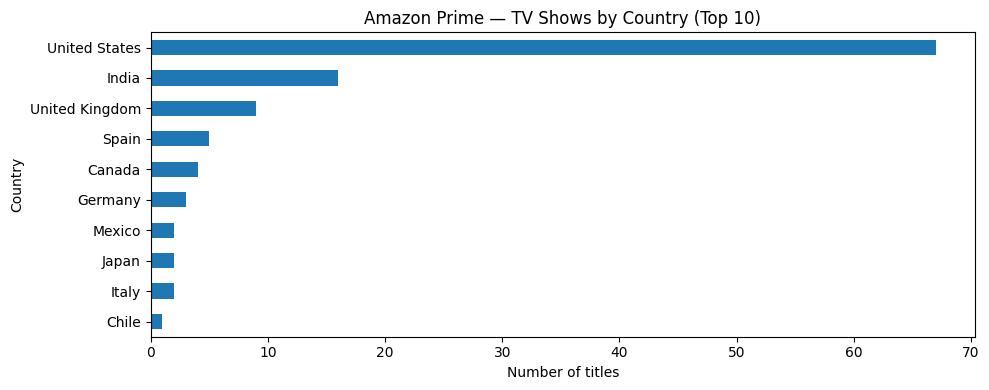

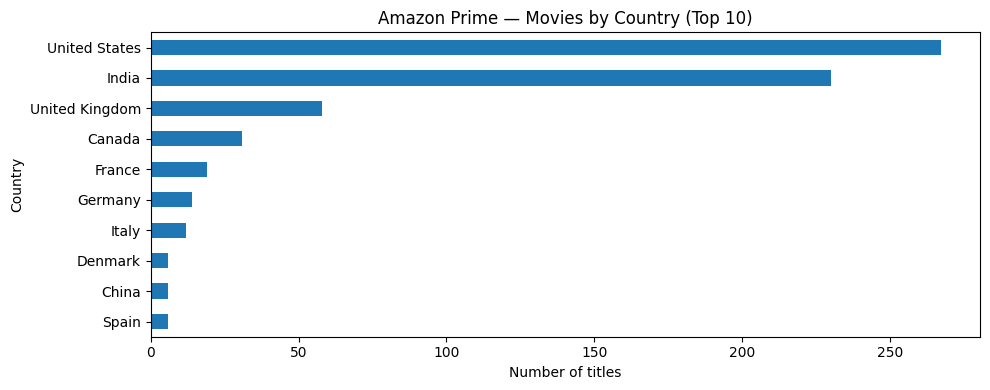

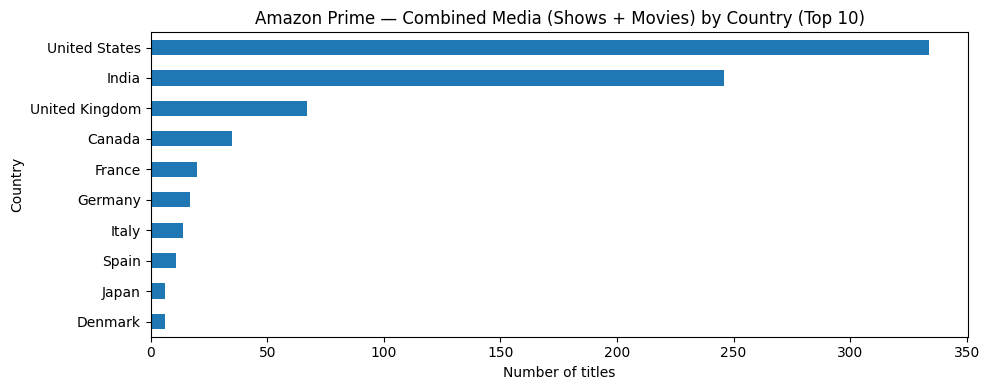

In [24]:
plot_top_countries(clean_shows_df["country"], "Amazon Prime — TV Shows by Country (Top 10)", top_n=10)
plot_top_countries(clean_movies_df["country"], "Amazon Prime — Movies by Country (Top 10)", top_n=10)
plot_top_countries(clean_amazon_df["country"], "Amazon Prime — Combined Media (Shows + Movies) by Country (Top 10)", top_n=10)

### *Observations on countries of streaming media production*
+ The catalogue is heavily dominated by the United States, with India & the UK forming a clear second tier
+ Movies show a stronger long-tail than TV (more countries appear in the top 10 / counts spread out faster).
+ Combined media largely mirrors movies because movies typically outnumber shows (if true in your dataset).